# Predicting the stock market values of MicroStrategy (Symbol: MSTR) using Multivariate Multi-Step LSTM (Multiple features, Multi-step target)

In [1]:
pip install yFinance

Note: you may need to restart the kernel to use updated packages.


### Importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import plotly.graph_objects as go
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Multiply, Concatenate, Add, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from tensorflow.keras.optimizers import Adam
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from pandas.tseries.holiday import USFederalHolidayCalendar, AbstractHolidayCalendar, Holiday

2024-12-14 12:49:23.606509: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Loading and Preprocessing the Data

In [3]:
# Retrieve Bitcoin and MSTR data
btc_data = yf.download('BTC-USD', start='2018-12-31', end='2034-12-31')
mstr_data = yf.download('MSTR', start='2018-12-31', end='2034-12-31')

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Flatten the Data 
Data from YFinance is multi-indexed, so it needs to flattened to be processed

In [4]:
#Flatten the MultiIndex columns into a single-level column index
# For BTC
btc_data.columns = [f'BTC_{col}' for col in btc_data.columns]

# For MSTR
mstr_data.columns = [f'MSTR_{col}' for col in mstr_data.columns]

In [5]:
btc_data.head()

BTC_('Adj Close', 'BTC-USD')  BTC_('Close', 'BTC-USD')  \
Date                                                                 
2018-12-31                   3742.700439               3742.700439   
2019-01-01                   3843.520020               3843.520020   
2019-01-02                   3943.409424               3943.409424   
2019-01-03                   3836.741211               3836.741211   
2019-01-04                   3857.717529               3857.717529   

            BTC_('High', 'BTC-USD')  BTC_('Low', 'BTC-USD')  \
Date                                                          
2018-12-31              3868.742920             3725.867432   
2019-01-01              3850.913818             3707.231201   
2019-01-02              3947.981201             3817.409424   
2019-01-03              3935.685059             3826.222900   
2019-01-04              3865.934570             3783.853760   

            BTC_('Open', 'BTC-USD')  BTC_('Volume', 'BTC-USD')  
Date                                                            
2018-12-31              3866.839111                 4661840806  
2019-01-01              3746.713379                 4324200990  
2019-01-02              3849.216309                 5244856836  
2019-01-03              3931.048584                 4530215219  
2019-01-04              3832.040039                 4847965467

In [6]:
btc_data.columns = ['BTC_Adj Close', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open','BTC_Volume']

In [7]:
btc_data.head()

BTC_Adj Close    BTC_Close     BTC_High      BTC_Low     BTC_Open  \
Date                                                                            
2018-12-31    3742.700439  3742.700439  3868.742920  3725.867432  3866.839111   
2019-01-01    3843.520020  3843.520020  3850.913818  3707.231201  3746.713379   
2019-01-02    3943.409424  3943.409424  3947.981201  3817.409424  3849.216309   
2019-01-03    3836.741211  3836.741211  3935.685059  3826.222900  3931.048584   
2019-01-04    3857.717529  3857.717529  3865.934570  3783.853760  3832.040039   

            BTC_Volume  
Date                    
2018-12-31  4661840806  
2019-01-01  4324200990  
2019-01-02  5244856836  
2019-01-03  4530215219  
2019-01-04  4847965467

In [8]:
mstr_data.head()

MSTR_('Adj Close', 'MSTR')  MSTR_('Close', 'MSTR')  \
Date                                                             
2018-12-31                      12.775                  12.775   
2019-01-02                      12.857                  12.857   
2019-01-03                      12.657                  12.657   
2019-01-04                      13.040                  13.040   
2019-01-07                      13.123                  13.123   

            MSTR_('High', 'MSTR')  MSTR_('Low', 'MSTR')  \
Date                                                      
2018-12-31                 12.819                12.563   
2019-01-02                 12.901                12.604   
2019-01-03                 12.870                12.597   
2019-01-04                 13.102                12.644   
2019-01-07                 13.271                13.039   

            MSTR_('Open', 'MSTR')  MSTR_('Volume', 'MSTR')  
Date                                                        
2018-12-31                 12.709                   999000  
2019-01-02                 12.604                   931000  
2019-01-03                 12.776                  1083000  
2019-01-04                 12.745                  1198000  
2019-01-07                 13.039                   747000

In [9]:
mstr_data.columns = ['MSTR_Adj Close', 'MSTR_Close', 'MSTR_High', 'MSTR_Low', 'MSTR_Open','MSTR_Volume']

### Exploratory Data Analysis (EDA)

In [10]:
mstr_data.columns

Index(['MSTR_Adj Close', 'MSTR_Close', 'MSTR_High', 'MSTR_Low', 'MSTR_Open',
       'MSTR_Volume'],
      dtype='object')

In [11]:
btc_data.columns

Index(['BTC_Adj Close', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open',
       'BTC_Volume'],
      dtype='object')

The count is different for bitcoin and MSTR likely because Bitcoin is open 24-7 while MSTR only moves during market hours.

In [12]:
btc_data.describe()

BTC_Adj Close      BTC_Close       BTC_High        BTC_Low  \
count    2176.000000    2176.000000    2176.000000    2176.000000   
mean    30971.064798   30971.064798   31612.783403   30224.448029   
std     21407.266473   21407.266473   21850.200537   20877.662691   
min      3399.471680    3399.471680    3427.945557    3391.023682   
25%     10527.593018   10527.593018   10731.323486   10259.040527   
50%     27201.905273   27201.905273   27555.352539   26761.322266   
75%     46070.299805   46070.299805   47114.498047   44373.805664   
max    101459.257812  101459.257812  103900.468750  100880.148438   

            BTC_Open    BTC_Volume  
count    2176.000000  2.176000e+03  
mean    30928.434216  3.020798e+10  
std     21364.941969  1.888020e+10  
min      3401.376465  4.324201e+09  
25%     10518.987305  1.781168e+10  
50%     27167.071289  2.667247e+10  
75%     45908.633789  3.739814e+10  
max    101434.617188  3.509679e+11

In [13]:
mstr_data.describe()

MSTR_Adj Close   MSTR_Close    MSTR_High     MSTR_Low    MSTR_Open  \
count     1500.000000  1500.000000  1500.000000  1500.000000  1500.000000   
mean        52.974628    52.974628    54.998613    51.041137    53.067799   
std         62.491426    62.491426    66.078184    59.523297    63.128973   
min          9.220000     9.220000    10.415000     9.000000     9.176000   
25%         14.849000    14.849000    15.028750    14.665500    14.860750   
50%         31.251000    31.251000    32.216501    30.004000    31.182500   
75%         62.107500    62.107500    63.691249    60.156749    62.032501   
max        473.829987   473.829987   543.000000   457.299988   535.630005   

        MSTR_Volume  
count  1.500000e+03  
mean   7.244803e+06  
std    8.393901e+06  
min    2.340000e+05  
25%    1.203500e+06  
50%    5.204500e+06  
75%    9.239750e+06  
max    1.004440e+08

In [14]:
mstr_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1500 entries, 2018-12-31 to 2024-12-13
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   MSTR_Adj Close  1500 non-null   float64
 1   MSTR_Close      1500 non-null   float64
 2   MSTR_High       1500 non-null   float64
 3   MSTR_Low        1500 non-null   float64
 4   MSTR_Open       1500 non-null   float64
 5   MSTR_Volume     1500 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 82.0 KB


In [15]:
btc_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2176 entries, 2018-12-31 to 2024-12-14
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   BTC_Adj Close  2176 non-null   float64
 1   BTC_Close      2176 non-null   float64
 2   BTC_High       2176 non-null   float64
 3   BTC_Low        2176 non-null   float64
 4   BTC_Open       2176 non-null   float64
 5   BTC_Volume     2176 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 119.0 KB


#### Plotting the metrics to see how volatile MSTR and BTC are during different time periods
1. Zooming in and out allows for different time periods to be shown.

In [16]:
def plot_metrics(df,ticker):
    #First graph: Metrics as a Scatter Plot
    fig1 = go.Figure()

    # List of metrics to graph
    metrics = ['Adj Close','Close', 'High', 'Low', 'Open']

    # Loop through metrics 
    for metric in metrics:
        fig1.add_trace(
            go.Scatter(
                x=df.index, 
                y=df[f'{ticker}_{metric}'],  
                mode='lines',
                name=f"{metric}"  # Label each trace by its metric
            )
        )

    # Update layout
    fig1.update_layout(
        title=f"{ticker} Metrics Over Time",
        xaxis_title="Date",
        yaxis_title="Stock Price ($)",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white",
    )
    
    fig1.show()
    
    # Second Graph: Candle Stick Chart
    fig2 = go.Figure(
        data=[
            go.Candlestick(
                x=df.index,
                open=df[f'{ticker}_Open'],
                high=df[(f'{ticker}_High')],
                low=df[(f'{ticker}_Low')],
                close=df[(f'{ticker}_Close')],
                name=ticker
            )
        ]
    )

    # Update layout
    fig2.update_layout(
        title=f"{ticker} Candlestick Chart",
        xaxis_title="Date",
        yaxis_title="Stock Price ($)",
        template="plotly_white",
    )
    
    fig2.show()

    # Third graph: Volume
    fig3 = go.Figure()

    # Add Volume trace
    fig3.add_trace(
        go.Scatter(
            x=df.index,
            y=df[(f'{ticker}_Volume')],
            mode='lines+markers',  # Optional: Different style for Volume
            name="Volume"
        )
    )

    # Customize layout for the second graph
    fig3.update_layout(
        title=f"{ticker} Volume Over Time",
        xaxis_title="Date",
        yaxis_title="Volume",
        legend=dict(orientation="h", yanchor="bottom", y=1.02, xanchor="right", x=1),
        template="plotly_white",
    )

    fig3.show()

In [17]:
# Define the ticker symbol
MSTR = 'MSTR'
BTC = 'BTC'

In [18]:
#Call the function to plot MSTR data
plot_metrics(mstr_data,MSTR)
#Call the function to plot BTC data
plot_metrics(btc_data,BTC)

#### Check the Correlation of Opening Prices for MSTR and BTC.

<AxesSubplot:xlabel='BTC_Open', ylabel='MSTR_Open'>

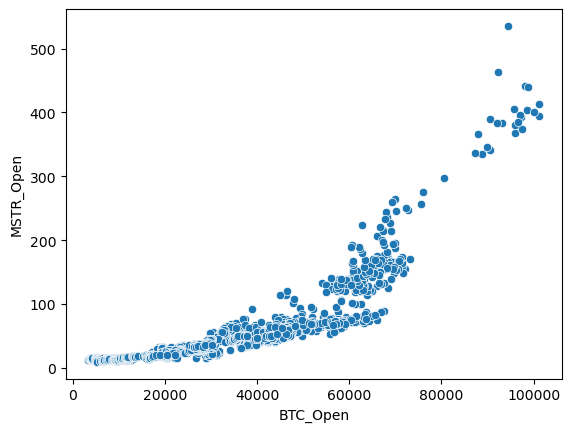

In [19]:
combined_prices = mstr_data[['MSTR_Open']].join(btc_data[['BTC_Open']])

sns.scatterplot(x=combined_prices['BTC_Open'], y=combined_prices['MSTR_Open'])

#### Compare Volatility 
Volatility is often defined as the standard deviation of daily returns, which reflects the asset's price fluctuations over time.


pct_change() calculates the daily return by this calculation: 
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}} = \frac{P_t}{P_{t-1}} - 1
$$

Where:
- \( R_t \): Change at time \( t \),
- \( P_t \): Value at time \( t \) (today's price),
- \( P_{t-1} \): Value at time \( t-1 \) (yesterday's price).

The daily return values are then used to calculate the standard deviation, specifically the rolling day standard deviation which is the volatility.

In [20]:
# Extract Open prices for Bitcoin and MSTR
btc_open = btc_data['BTC_Open']
mstr_open = mstr_data['MSTR_Open']

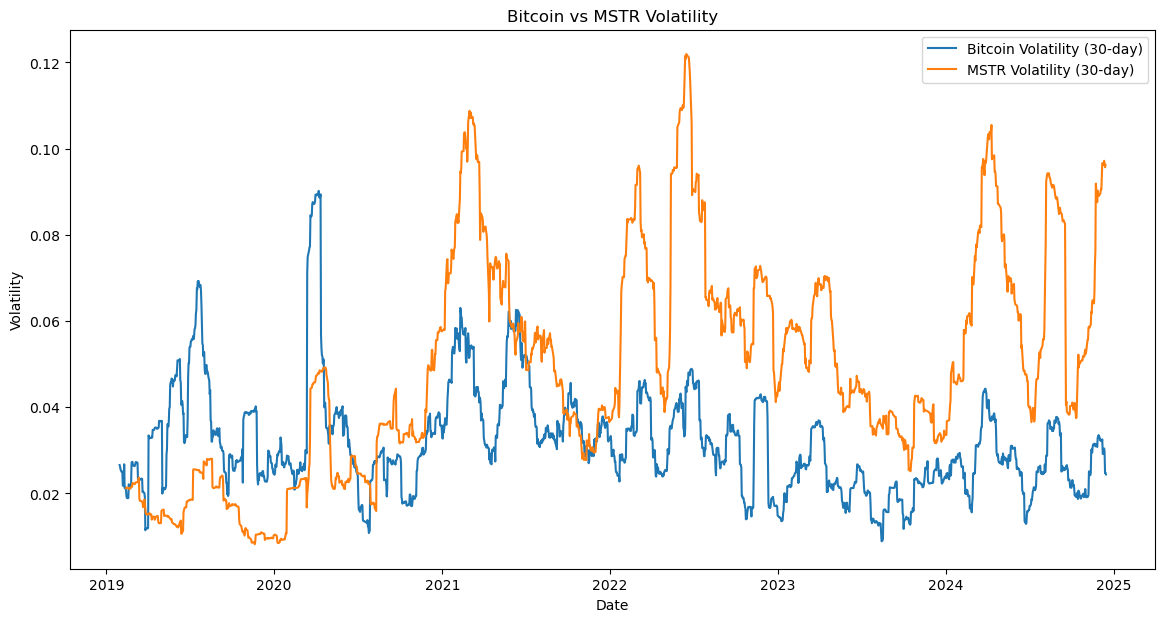

In [21]:
# Calculate daily returns for Bitcoin and MSTR
btc_returns = btc_open.pct_change() 
mstr_returns = mstr_open.pct_change()

# Calculate 10-day rolling standard deviation (volatility) for both assets
btc_volatility = btc_returns.rolling(window=30).std()
mstr_volatility = mstr_returns.rolling(window=30).std()

# Plot the volatility
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(btc_volatility, label="Bitcoin Volatility (30-day)")
plt.plot(mstr_volatility, label="MSTR Volatility (30-day)")
plt.legend()
plt.title('Bitcoin vs MSTR Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.show()

In [22]:
btc_returns = pd.DataFrame({
    'BTC_Returns': btc_returns
})
mstr_returns = pd.DataFrame({
    'MSTR_Returns': mstr_returns
})

In [23]:
btc_returns.head()

BTC_Returns
Date                   
2018-12-31          NaN
2019-01-01    -0.031066
2019-01-02     0.027358
2019-01-03     0.021259
2019-01-04    -0.025186

In [24]:
mstr_returns.head()

MSTR_Returns
Date                    
2018-12-31           NaN
2019-01-02     -0.008262
2019-01-03      0.013646
2019-01-04     -0.002426
2019-01-07      0.023068

#### Distribution of the Returns

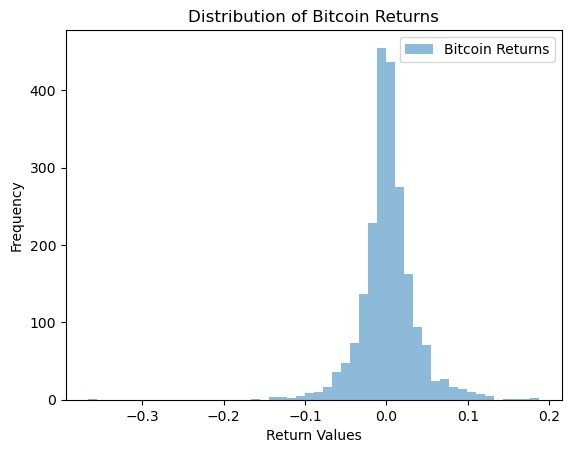

In [25]:
plt.hist(btc_returns, bins=50, alpha=0.5, label="Bitcoin Returns")
plt.xlabel('Return Values')  # X-axis label
plt.ylabel('Frequency')  # Y-axis label
plt.title('Distribution of Bitcoin Returns')  # Title of the plot
plt.legend()  # Display the legend
plt.show()

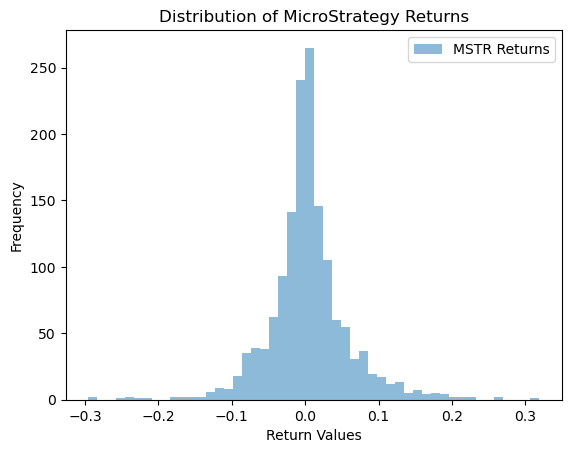

In [26]:
plt.hist(mstr_returns, bins=50, alpha=0.5, label="MSTR Returns")
plt.xlabel('Return Values')  
plt.ylabel('Frequency')  
plt.title('Distribution of MicroStrategy Returns') 
plt.legend()  
plt.show()

#### Check for missing values

In [27]:
print(btc_data.isnull().sum())

BTC_Adj Close    0
BTC_Close        0
BTC_High         0
BTC_Low          0
BTC_Open         0
BTC_Volume       0
dtype: int64


In [28]:
print(mstr_data.isnull().sum())

MSTR_Adj Close    0
MSTR_Close        0
MSTR_High         0
MSTR_Low          0
MSTR_Open         0
MSTR_Volume       0
dtype: int64


#### Check for outliers

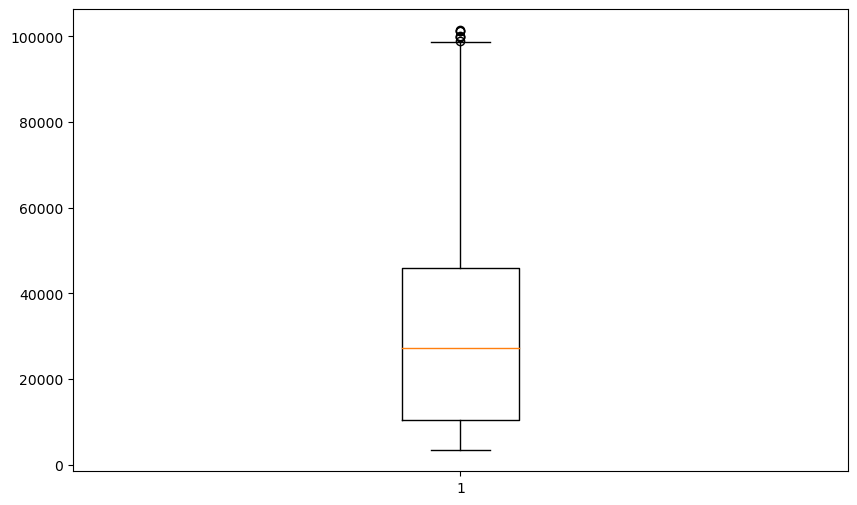

In [29]:
plt.figure(figsize=(10,6))
plt.boxplot(btc_open)
plt_boxplot = _

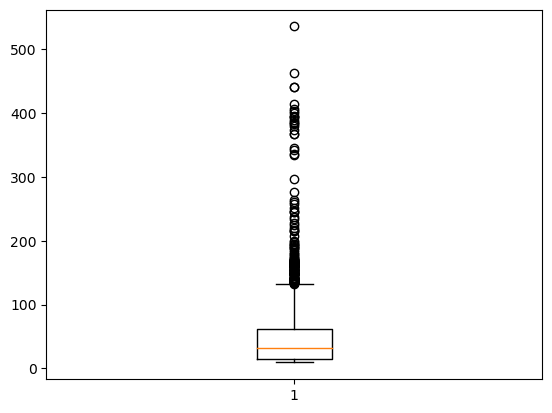

In [30]:
plt.boxplot(mstr_open)
plt_boxplot = _

#### Seasonal Decomposition

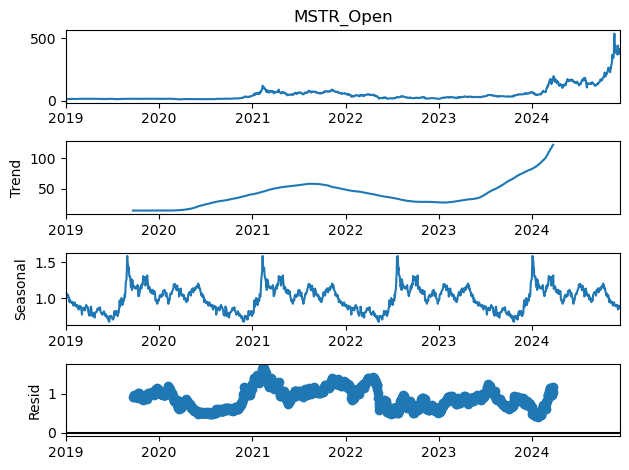

In [31]:
"""
Classical Time Series Decompositon: This breaks down time series data in to these parts: trend, seasonal,
residual. 

Trend: 
Trend captures the underlying behavior of the series. It neglects the short-term fluctuations, 
hence why the graph is so smooth.This shows the gradual changes in behavior over time. It can be determined 
if there exists a downward, flat, or upward trend.

Seasonality: 
This shows the recurring patterns over time, and occur at consistent time intervals. For example, the Santa Clause 
rally could be apart of this. Seasonality can be predictable and exhibit patterns in different time periods.

Residual: The residual component shows the random variations/noise that cannot be explained by a trend or 
seasonality. These are the unpredictable values. If there exists a pattern in this component, then a time series 
may not be the best model for the data. 
"""


decomposition = seasonal_decompose(mstr_open, model='multiplicative', period=365)
decomposition.plot()
plt.show()

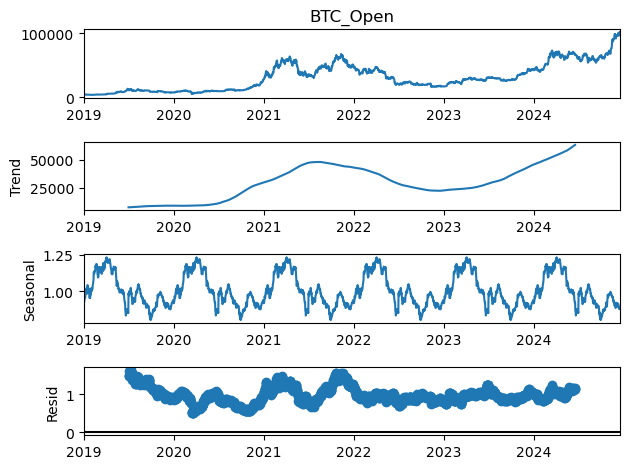

In [32]:
decomposition = seasonal_decompose(btc_open, model='multiplicative', period=365)
decomposition.plot()
plt.show()

#### Check for Auto-correlation
lags refer to the previous observations of a data series used to analyze its relationship with current or future values.

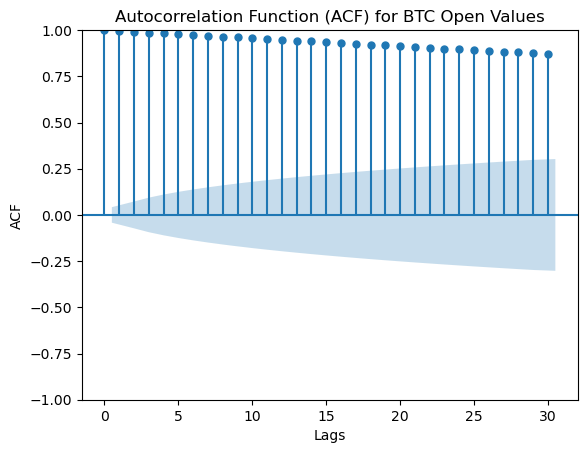

In [33]:
plot_acf(btc_open, lags=30)
plt.title(f'Autocorrelation Function (ACF) for BTC Open Values')
plt.xlabel('Lags') 
plt.ylabel('ACF')   
plt.show()

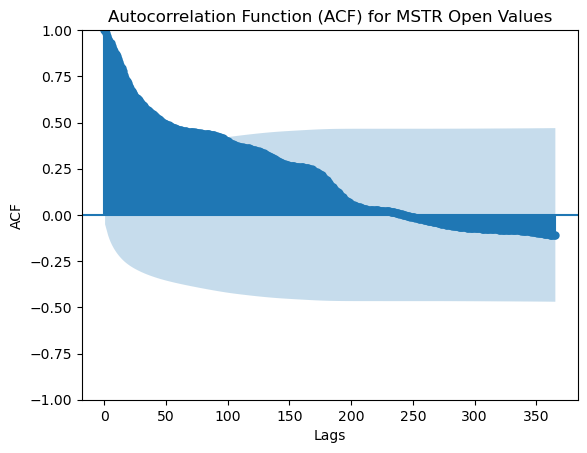

In [34]:
plot_acf(mstr_open, lags=365)
plt.title(f'Autocorrelation Function (ACF) for MSTR Open Values')
plt.xlabel('Lags')  
plt.ylabel('ACF')    
plt.show()

In [35]:
btc_data.columns

Index(['BTC_Adj Close', 'BTC_Close', 'BTC_High', 'BTC_Low', 'BTC_Open',
       'BTC_Volume'],
      dtype='object')

#### Feature Engineering: Add the Exponential Weighted Moving Average 
.ewm calculates the exponential weighted moving values, and the mean function is used to get the average

Exponential moving average places great importance on the more recent data points. 

In [36]:
btc_data['BTC_EMA_2'] = btc_data['BTC_Open'].ewm(span=2, adjust=False).mean()
btc_data['BTC_EMA_15'] = btc_data['BTC_Open'].ewm(span=15, adjust=False).mean()
btc_data.head(250)

BTC_Adj Close     BTC_Close      BTC_High       BTC_Low  \
Date                                                                  
2018-12-31    3742.700439   3742.700439   3868.742920   3725.867432   
2019-01-01    3843.520020   3843.520020   3850.913818   3707.231201   
2019-01-02    3943.409424   3943.409424   3947.981201   3817.409424   
2019-01-03    3836.741211   3836.741211   3935.685059   3826.222900   
2019-01-04    3857.717529   3857.717529   3865.934570   3783.853760   
...                   ...           ...           ...           ...   
2019-09-02   10346.760742  10346.760742  10396.591797   9730.650391   
2019-09-03   10623.540039  10623.540039  10736.104492  10308.547852   
2019-09-04   10594.493164  10594.493164  10762.644531  10434.709961   
2019-09-05   10575.533203  10575.533203  10627.269531  10516.417969   
2019-09-06   10353.302734  10353.302734  10898.761719  10292.299805   

                BTC_Open   BTC_Volume     BTC_EMA_2    BTC_EMA_15  
Date                                                               
2018-12-31   3866.839111   4661840806   3866.839111   3866.839111  
2019-01-01   3746.713379   4324200990   3786.755290   3851.823395  
2019-01-02   3849.216309   5244856836   3828.395969   3851.497509  
2019-01-03   3931.048584   4530215219   3896.831046   3861.441393  
2019-01-04   3832.040039   4847965467   3853.637041   3857.766224  
...                  ...          ...           ...           ...  
2019-09-02   9757.473633  17248102294   9713.403607  10053.276514  
2019-09-03  10345.725586  19384917989  10134.951593  10089.832648  
2019-09-04  10621.180664  16742664769  10459.104307  10156.251150  
2019-09-05  10588.183594  14551239508  10545.157165  10210.242705  
2019-09-06  10578.198242  19536574783  10567.184550  10256.237147  

[250 rows x 8 columns]

In [37]:
print(btc_data.isnull().sum())  # Check for NaN values
print(type(btc_data['BTC_Open']))

BTC_Adj Close    0
BTC_Close        0
BTC_High         0
BTC_Low          0
BTC_Open         0
BTC_Volume       0
BTC_EMA_2        0
BTC_EMA_15       0
dtype: int64
<class 'pandas.core.series.Series'>


In [38]:
mstr_data['MSTR_EMA_2'] = mstr_data['MSTR_Open'].ewm(span=2, adjust=False).mean()
mstr_data['MSTR_EMA_15'] = mstr_data['MSTR_Open'].ewm(span=15, adjust=False).mean()
mstr_data.head(250)

MSTR_Adj Close  MSTR_Close  MSTR_High  MSTR_Low  MSTR_Open  \
Date                                                                     
2018-12-31          12.775      12.775     12.819    12.563     12.709   
2019-01-02          12.857      12.857     12.901    12.604     12.604   
2019-01-03          12.657      12.657     12.870    12.597     12.776   
2019-01-04          13.040      13.040     13.102    12.644     12.745   
2019-01-07          13.123      13.123     13.271    13.039     13.039   
...                    ...         ...        ...       ...        ...   
2019-12-19          14.595      14.595     14.631    14.463     14.593   
2019-12-20          14.520      14.520     14.631    14.484     14.600   
2019-12-23          14.433      14.433     14.555    14.406     14.555   
2019-12-24          14.440      14.440     14.460    14.380     14.399   
2019-12-26          14.505      14.505     14.535    14.422     14.493   

            MSTR_Volume  MSTR_EMA_2  MSTR_EMA_15  
Date                                              
2018-12-31       999000   12.709000    12.709000  
2019-01-02       931000   12.639000    12.695875  
2019-01-03      1083000   12.730333    12.705890  
2019-01-04      1198000   12.740111    12.710779  
2019-01-07       747000   12.939370    12.751807  
...                 ...         ...          ...  
2019-12-19       465000   14.638979    14.918742  
2019-12-20      1151000   14.612993    14.878899  
2019-12-23       571000   14.574331    14.838412  
2019-12-24       322000   14.457444    14.783485  
2019-12-26       253000   14.481148    14.747175  

[250 rows x 8 columns]

#### Feature Engineering Continued: Adding the Returns as a Feature

In [39]:
btc_data['BTC_Returns (%)'] = btc_returns['BTC_Returns'] * 100
btc_data.head()

BTC_Adj Close    BTC_Close     BTC_High      BTC_Low     BTC_Open  \
Date                                                                            
2018-12-31    3742.700439  3742.700439  3868.742920  3725.867432  3866.839111   
2019-01-01    3843.520020  3843.520020  3850.913818  3707.231201  3746.713379   
2019-01-02    3943.409424  3943.409424  3947.981201  3817.409424  3849.216309   
2019-01-03    3836.741211  3836.741211  3935.685059  3826.222900  3931.048584   
2019-01-04    3857.717529  3857.717529  3865.934570  3783.853760  3832.040039   

            BTC_Volume    BTC_EMA_2   BTC_EMA_15  BTC_Returns (%)  
Date                                                               
2018-12-31  4661840806  3866.839111  3866.839111              NaN  
2019-01-01  4324200990  3786.755290  3851.823395        -3.106561  
2019-01-02  5244856836  3828.395969  3851.497509         2.735809  
2019-01-03  4530215219  3896.831046  3861.441393         2.125946  
2019-01-04  4847965467  3853.637041  3857.766224        -2.518629

In [40]:
mstr_data['MSTR_Returns (%)'] = mstr_returns['MSTR_Returns'] * 100
mstr_data.head()

MSTR_Adj Close  MSTR_Close  MSTR_High  MSTR_Low  MSTR_Open  \
Date                                                                     
2018-12-31          12.775      12.775     12.819    12.563     12.709   
2019-01-02          12.857      12.857     12.901    12.604     12.604   
2019-01-03          12.657      12.657     12.870    12.597     12.776   
2019-01-04          13.040      13.040     13.102    12.644     12.745   
2019-01-07          13.123      13.123     13.271    13.039     13.039   

            MSTR_Volume  MSTR_EMA_2  MSTR_EMA_15  MSTR_Returns (%)  
Date                                                                
2018-12-31       999000   12.709000    12.709000               NaN  
2019-01-02       931000   12.639000    12.695875         -0.826183  
2019-01-03      1083000   12.730333    12.705890          1.364646  
2019-01-04      1198000   12.740111    12.710779         -0.242644  
2019-01-07       747000   12.939370    12.751807          2.306784

In [41]:
print(btc_data.isnull().sum())
print(mstr_data.isnull().sum())

BTC_Adj Close      0
BTC_Close          0
BTC_High           0
BTC_Low            0
BTC_Open           0
BTC_Volume         0
BTC_EMA_2          0
BTC_EMA_15         0
BTC_Returns (%)    1
dtype: int64
MSTR_Adj Close      0
MSTR_Close          0
MSTR_High           0
MSTR_Low            0
MSTR_Open           0
MSTR_Volume         0
MSTR_EMA_2          0
MSTR_EMA_15         0
MSTR_Returns (%)    1
dtype: int64


#### Remove the missing values. 

In [42]:
btc_data = btc_data.dropna()
mstr_data = mstr_data.dropna()

#### Removing weekends and holidays (only stock market holidays)

In [43]:
btc_data.describe()

BTC_Adj Close      BTC_Close       BTC_High        BTC_Low  \
count    2175.000000    2175.000000    2175.000000    2175.000000   
mean    30983.583586   30983.583586   31625.539283   30236.631285   
std     21404.220948   21404.220948   21847.119899   20874.725358   
min      3399.471680    3399.471680    3427.945557    3391.023682   
25%     10534.596191   10534.596191   10736.473633   10278.851562   
50%     27211.117188   27211.117188   27621.941406   26762.648438   
75%     46077.330078   46077.330078   47122.855469   44383.583984   
max    101459.257812  101459.257812  103900.468750  100880.148438   

            BTC_Open    BTC_Volume      BTC_EMA_2    BTC_EMA_15  \
count    2175.000000  2.175000e+03    2175.000000   2175.000000   
mean    30940.876328  3.021973e+10   30918.557775  30637.052804   
std     21361.968441  1.887659e+10   21327.115485  20936.864171   
min      3401.376465  4.324201e+09    3411.689696   3496.831732   
25%     10522.548828  1.783394e+10   10516.119326  10631.699151   
50%     27171.513672  2.667797e+10   27117.823643  27168.242676   
75%     45917.908203  3.740859e+10   45922.459114  44743.261843   
max    101434.617188  3.509679e+11  100952.546361  98269.148349   

       BTC_Returns (%)  
count      2175.000000  
mean          0.208831  
std           3.400275  
min         -36.592439  
25%          -1.256488  
50%           0.074551  
75%           1.651749  
max          18.767702

In [44]:
mstr_data.describe()

MSTR_Adj Close   MSTR_Close    MSTR_High     MSTR_Low    MSTR_Open  \
count     1499.000000  1499.000000  1499.000000  1499.000000  1499.000000   
mean        53.001446    53.001446    55.026751    51.066807    53.094723   
std         62.503646    62.503646    66.091246    59.534855    63.141425   
min          9.220000     9.220000    10.415000     9.000000     9.176000   
25%         14.855000    14.855000    15.034000    14.667500    14.863500   
50%         31.278000    31.278000    32.233002    30.108000    31.230000   
75%         62.124001    62.124001    63.789499    60.275499    62.033001   
max        473.829987   473.829987   543.000000   457.299988   535.630005   

        MSTR_Volume   MSTR_EMA_2  MSTR_EMA_15  MSTR_Returns (%)  
count  1.499000e+03  1499.000000  1499.000000       1499.000000  
mean   7.248970e+06    52.965093    51.329873          0.382979  
std    8.395150e+06    62.689347    57.617836          5.533042  
min    2.340000e+05     9.611060    11.103618        -29.534191  
25%    1.204500e+06    14.844956    14.786490         -1.996987  
50%    5.206000e+06    31.141628    30.161374          0.121626  
75%    9.243500e+06    62.215110    61.204796          2.503221  
max    1.004440e+08   501.634677   390.638856         31.901554

### Preparing Data for LSTM

#### Splitting the data into test and train sets

In [45]:
print(btc_data.index)

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2024-12-05', '2024-12-06', '2024-12-07', '2024-12-08',
               '2024-12-09', '2024-12-10', '2024-12-11', '2024-12-12',
               '2024-12-13', '2024-12-14'],
              dtype='datetime64[ns]', name='Date', length=2175, freq=None)


In [46]:
# Ensure data is sorted by date before splitting
btc_data_sorted = btc_data.sort_values(by='Date') 
# Calculate the split index
split_index_btc = int(len(btc_data_sorted) * 0.8)

# Split the data into training and testing
train_btc = btc_data_sorted.iloc[:split_index_btc]  # First 80% of the data
test_btc = btc_data_sorted.iloc[split_index_btc:]   # Remaining 20% of the data

In [47]:
# Ensure data is sorted by date before splitting
mstr_data_sorted = mstr_data.sort_values(by='Date') 
# Calculate the split index
split_index_mstr = int(len(mstr_data_sorted) * 0.8)

# Split the data into training and testing
train_mstr = mstr_data_sorted.iloc[:split_index_mstr]  # First 80% of the data
test_mstr = mstr_data_sorted.iloc[split_index_mstr:]   # Remaining 20% of the data

In [48]:
train_btc.head()

BTC_Adj Close    BTC_Close     BTC_High      BTC_Low     BTC_Open  \
Date                                                                            
2019-01-01    3843.520020  3843.520020  3850.913818  3707.231201  3746.713379   
2019-01-02    3943.409424  3943.409424  3947.981201  3817.409424  3849.216309   
2019-01-03    3836.741211  3836.741211  3935.685059  3826.222900  3931.048584   
2019-01-04    3857.717529  3857.717529  3865.934570  3783.853760  3832.040039   
2019-01-05    3845.194580  3845.194580  3904.903076  3836.900146  3851.973877   

            BTC_Volume    BTC_EMA_2   BTC_EMA_15  BTC_Returns (%)  
Date                                                               
2019-01-01  4324200990  3786.755290  3851.823395        -3.106561  
2019-01-02  5244856836  3828.395969  3851.497509         2.735809  
2019-01-03  4530215219  3896.831046  3861.441393         2.125946  
2019-01-04  4847965467  3853.637041  3857.766224        -2.518629  
2019-01-05  5137609824  3852.528265  3857.042181         0.520189

In [49]:
test_btc.head()

BTC_Adj Close     BTC_Close      BTC_High       BTC_Low  \
Date                                                                  
2023-10-07   27968.839844  27968.839844  28028.091797  27870.423828   
2023-10-08   27935.089844  27935.089844  28102.169922  27740.662109   
2023-10-09   27583.677734  27583.677734  27989.470703  27302.562500   
2023-10-10   27391.019531  27391.019531  27715.847656  27301.654297   
2023-10-11   26873.320312  26873.320312  27474.115234  26561.099609   

                BTC_Open   BTC_Volume     BTC_EMA_2    BTC_EMA_15  \
Date                                                                
2023-10-07  27946.781250   6553044316  27799.298001  27198.660675   
2023-10-08  27971.677734   7916875290  27914.217823  27295.287808   
2023-10-09  27934.472656  12007668568  27927.721045  27375.185914   
2023-10-10  27589.201172   9973350678  27702.041130  27401.937821   
2023-10-11  27392.076172  13648094333  27495.397824  27400.705115   

            BTC_Returns (%)  
Date                         
2023-10-07         1.950444  
2023-10-08         0.089085  
2023-10-09        -0.133010  
2023-10-10        -1.236005  
2023-10-11        -0.714501

In [50]:
train_mstr.head()

MSTR_Adj Close  MSTR_Close  MSTR_High  MSTR_Low  MSTR_Open  \
Date                                                                     
2019-01-02          12.857      12.857     12.901    12.604     12.604   
2019-01-03          12.657      12.657     12.870    12.597     12.776   
2019-01-04          13.040      13.040     13.102    12.644     12.745   
2019-01-07          13.123      13.123     13.271    13.039     13.039   
2019-01-08          13.231      13.231     13.266    12.972     13.213   

            MSTR_Volume  MSTR_EMA_2  MSTR_EMA_15  MSTR_Returns (%)  
Date                                                                
2019-01-02       931000   12.639000    12.695875         -0.826183  
2019-01-03      1083000   12.730333    12.705890          1.364646  
2019-01-04      1198000   12.740111    12.710779         -0.242644  
2019-01-07       747000   12.939370    12.751807          2.306784  
2019-01-08      1083000   13.121790    12.809456          1.334464

In [51]:
test_mstr.head()

MSTR_Adj Close  MSTR_Close  MSTR_High   MSTR_Low  MSTR_Open  \
Date                                                                      
2023-10-06       34.063000   34.063000  34.178001  31.917000  32.000000   
2023-10-09       34.044998   34.044998  34.424000  33.143002  33.153000   
2023-10-10       34.046001   34.046001  34.646999  33.701000  34.124001   
2023-10-11       33.460999   33.460999  34.027000  33.035000  33.860001   
2023-10-12       32.360001   32.360001  33.500000  32.085999  33.500000   

            MSTR_Volume  MSTR_EMA_2  MSTR_EMA_15  MSTR_Returns (%)  
Date                                                                
2023-10-06      4732000   32.081175    32.981535         -1.170517  
2023-10-09      3807000   32.795725    33.002968          3.603125  
2023-10-10      3866000   33.681242    33.143097          2.928847  
2023-10-11      3063000   33.800414    33.232710         -0.773649  
2023-10-12      4451000   33.600138    33.266121         -1.063203

### Scaling the Data 
This ensures a mean of 0 and a standard deviation of 1.

#### Check for normally distributed columns 

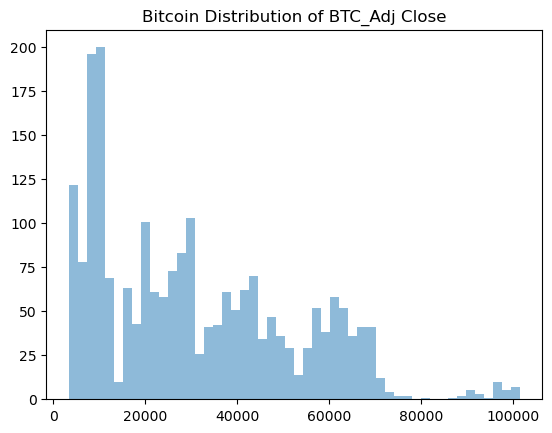

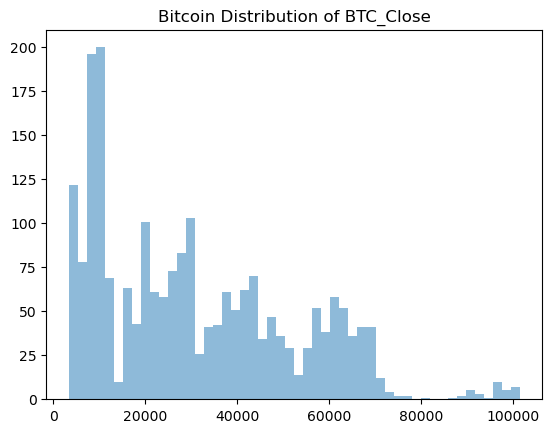

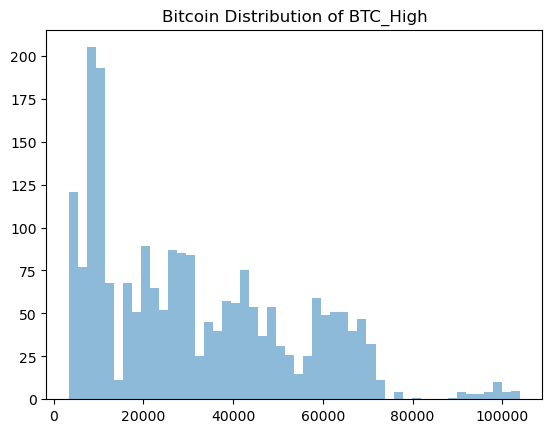

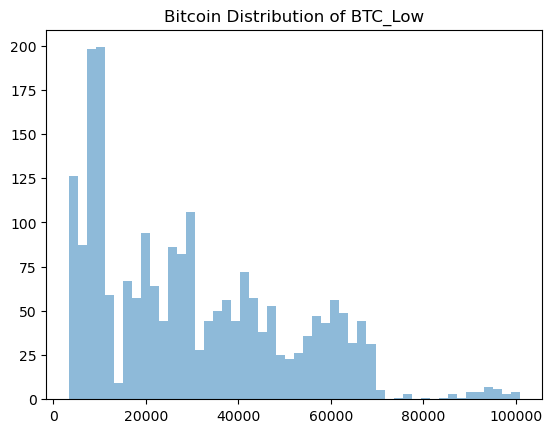

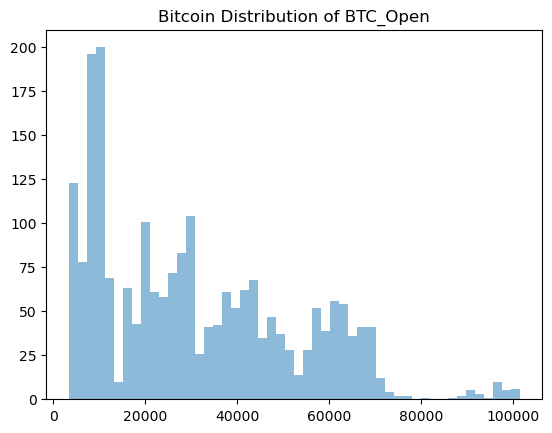

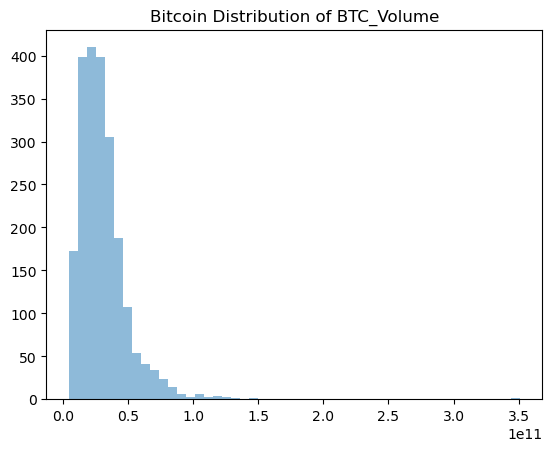

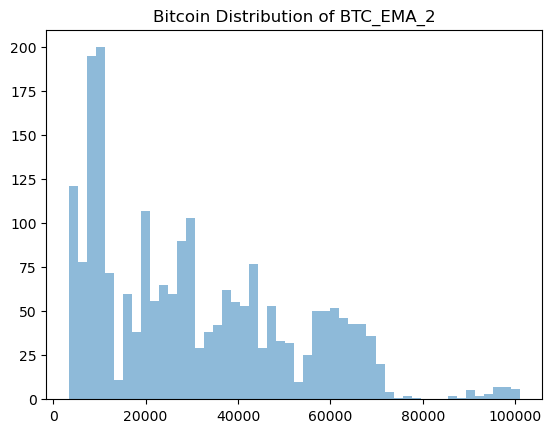

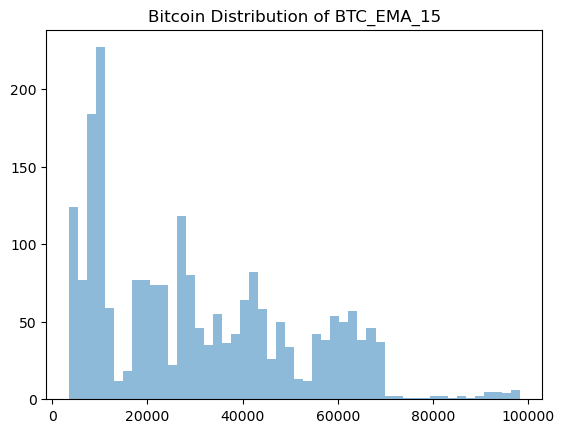

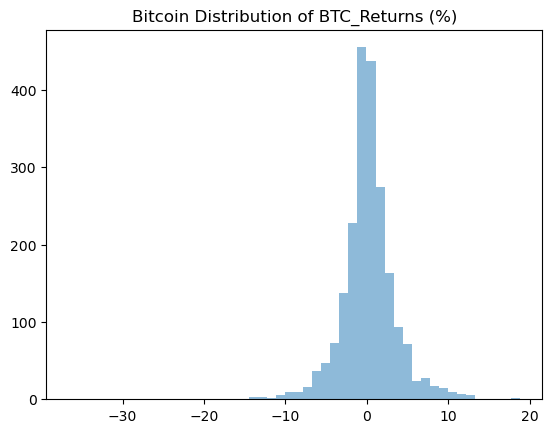

In [52]:
for column in btc_data.columns: 
    # Plot the histogram for each column
    plt.hist(btc_data[column], bins=50, alpha=0.5)
    plt.title(f"Bitcoin Distribution of {column}")
    plt.show()

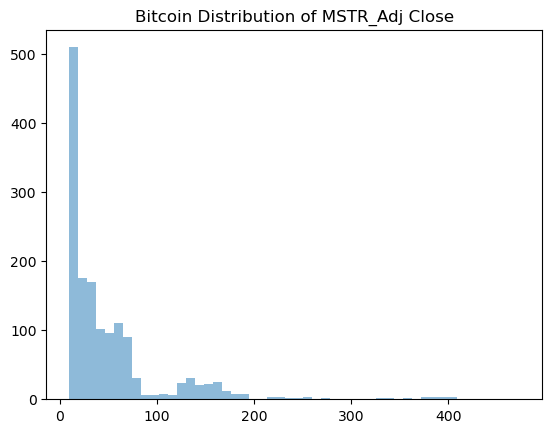

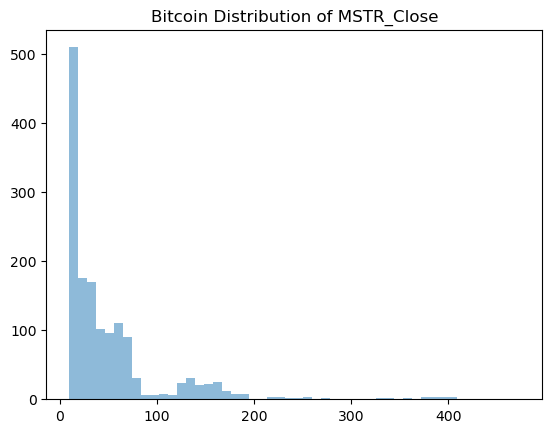

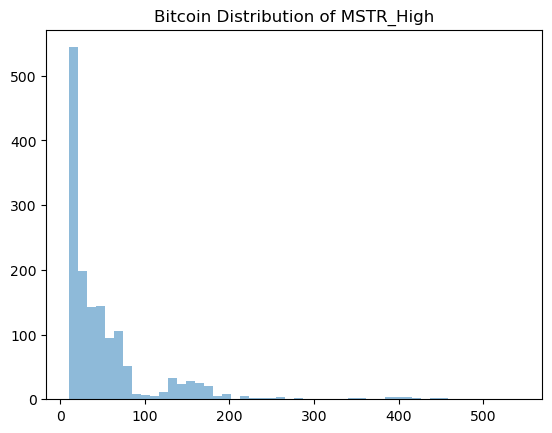

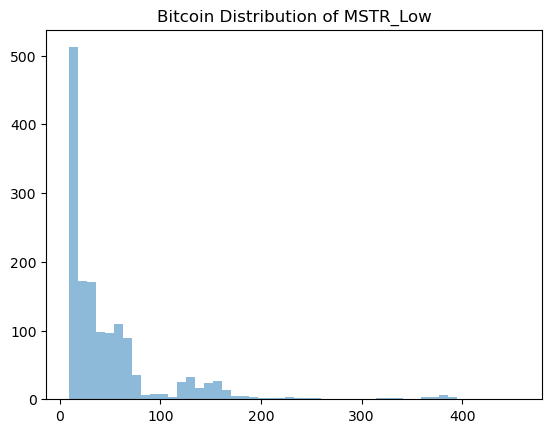

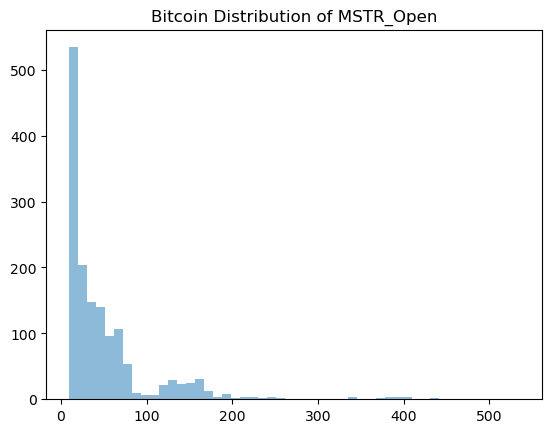

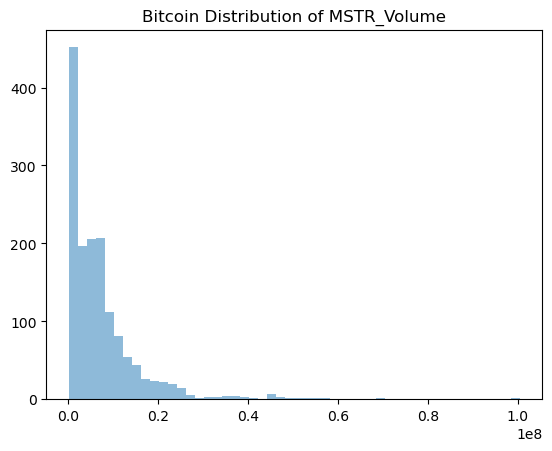

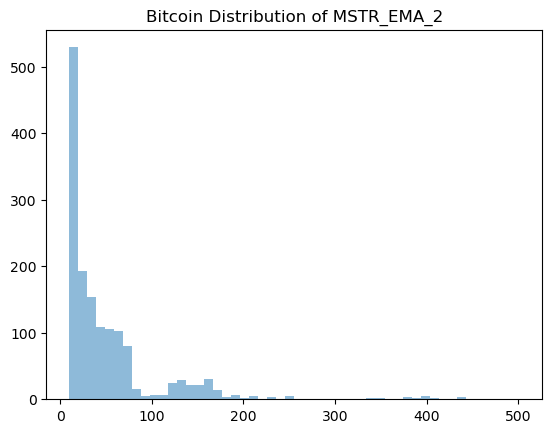

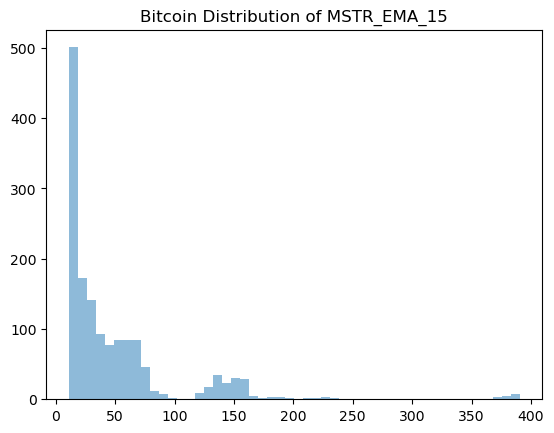

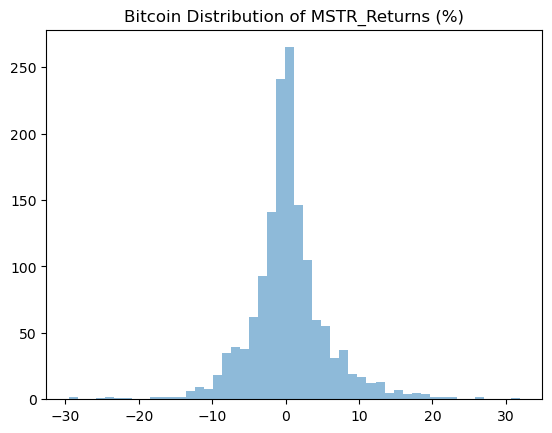

In [53]:
for column in mstr_data.columns: 
    # Plot the histogram for each column
    plt.hist(mstr_data[column], bins=50, alpha=0.5)
    plt.title(f"Bitcoin Distribution of {column}")
    plt.show()

In [54]:
print(type(train_mstr))
print(type(test_mstr))
print(type(train_btc))
print(type(test_btc))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


#### Scaling the Data

In [55]:
#Scale MSTR features (all 9 features, including past MSTR Open) 
feature_scaler_mstr = StandardScaler()
scaled_train_mstr = feature_scaler_mstr.fit_transform(train_mstr)  # Fit on train MSTR
scaled_test_mstr = feature_scaler_mstr.transform(test_mstr)        # Transform test MSTR

#Scale BTC features (all 9 features)
feature_scaler_btc = StandardScaler()
scaled_train_btc = feature_scaler_btc.fit_transform(train_btc)  # Fit on train BTC
scaled_test_btc = feature_scaler_btc.transform(test_btc)        # Transform test BTC

#Extract the MSTR Open column (5th feature) for target scaling
mstr_open_train = train_mstr[['MSTR_Open']].to_numpy().reshape(-1, 1)  # Extract as 2D array (n_samples, 1)
target_scaler = StandardScaler()
scaled_mstr_open_train = target_scaler.fit_transform(mstr_open_train)  # Fit only on training MSTR Open

#Transform the test set MSTR Open values
mstr_open_test = test_mstr[['MSTR_Open']].to_numpy().reshape(-1, 1)  # Extract and reshape to (n_samples, 1)
scaled_mstr_open_test = target_scaler.transform(mstr_open_test)  # Transform MSTR Open test

#Extract Actual Values of MSTR Open for Comparison
df_mstr_actual_open = pd.DataFrame(mstr_data['MSTR_Open'])

In [56]:
df_mstr_actual_open.tail()

MSTR_Open
Date                  
2024-12-09  394.000000
2024-12-10  373.369995
2024-12-11  385.660004
2024-12-12  413.709991
2024-12-13  400.070007

In [57]:
print(scaled_train_mstr.shape)
print(scaled_test_mstr.shape)
print(scaled_train_btc.shape)
print(scaled_test_btc.shape)

(1199, 9)
(300, 9)
(1740, 9)
(435, 9)


### Building the LSTM Model

In [58]:
target_column = 'MSTR_Open'
target_index_mstr = train_mstr.columns.get_loc(target_column)

In [59]:
scaled_train_mstr

array([[-8.81847087e-01, -8.81847087e-01, -8.89961044e-01, ...,
        -8.89873836e-01, -8.97848204e-01, -2.00818096e-01],
       [-8.91495202e-01, -8.91495202e-01, -8.91397397e-01, ...,
        -8.85490720e-01, -8.97358811e-01,  2.23339280e-01],
       [-8.73019114e-01, -8.73019114e-01, -8.80647949e-01, ...,
        -8.85021485e-01, -8.97119935e-01, -8.78414604e-02],
       ...,
       [-2.05742514e-04, -2.05742514e-04,  2.27676171e-02, ...,
         8.47471215e-02,  1.17567971e-01, -1.30728972e+00],
       [ 4.35483644e-02,  4.35483644e-02,  1.31766716e-02, ...,
         3.79499378e-02,  1.05402102e-01, -5.81812526e-01],
       [ 5.81168728e-02,  5.81168728e-02,  3.20344044e-02, ...,
         5.09531262e-02,  1.00217389e-01,  5.08870288e-01]])

In [60]:
scaled_train_mstr.shape

(1199, 9)

In [61]:
scaled_train_btc.shape

(1740, 9)

In [62]:
"""
This code prepares the sliding windows by using the last 90 days
to predict the next 30 days. Seperate loops were made for MSTR and BTC
which generates X_train (the inputs) and the target value (y_train).
The inputs include all features, and the data is convereted to NumPy 
arrays so that the data will be compatible with the LSTM model."""

X_train_mstr = []
y_train_mstr = []
X_train_btc = []
y_train_btc = []

n_future = 30   # Predict into the future (one day)
n_past = 90      # Use past 90 days

# Create sliding windows
for i in range(n_past, len(scaled_train_mstr) - n_future + 1):
    X_train_mstr.append(scaled_train_mstr[i - n_past:i, :])  # Last 90 days
    y_train_mstr.append(scaled_train_mstr[i:i + n_future, -1])  # Open price of MSTR on the n_future-th day

X_train_mstr = np.array(X_train_mstr)  # Shape: (num_samples, n_past, num_features)
y_train_mstr = np.array(y_train_mstr)  # Shape: (num_samples,)

# Create sliding windows
for i in range(n_past, len(scaled_train_btc) - n_future + 1):
    X_train_btc.append(scaled_train_btc[i - n_past:i, :])  # Last 90 days
    y_train_btc.append(scaled_train_btc[i:i + n_future, -1])  # Open price of BTC on the n_future-th day

X_train_btc = np.array(X_train_btc)  # Shape: (num_samples, n_past, num_features)
y_train_btc = np.array(y_train_btc)  # Shape: (num_samples, n_future)



In [63]:
print(X_train_mstr.shape)
print(X_train_btc.shape)

(1080, 90, 9)
(1621, 90, 9)


In [64]:
# These should have the shape (number_samples, n_future)
print(y_train_mstr.shape) 
print(y_train_btc.shape)

(1080, 30)
(1621, 30)


In [65]:
# Prepare X_test for MSTR and BTC using sliding windows (same as training)
X_test_mstr = []
X_test_btc = []

for i in range(n_past, len(scaled_test_mstr) - n_future + 1):
    # Use the past 90 days (n_past) of data for MSTR and BTC to predict the future 365 days (n_future)
    X_test_mstr.append(scaled_test_mstr[i - n_past:i, :])  # Past data for MSTR
    X_test_btc.append(scaled_test_btc[i - n_past:i, :])    # Past data for BTC

# Convert to numpy arrays for model 
X_test_mstr = np.array(X_test_mstr)
X_test_btc = np.array(X_test_btc)

In [66]:
# Define MSTR input
input_mstr = Input(shape=(X_train_mstr.shape[1], X_train_mstr.shape[2]), name='MSTR_Input')
lstm_mstr_1 = LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001))(input_mstr)
lstm_mstr_2 = LSTM(100, return_sequences=False, kernel_regularizer=l2(0.001))(lstm_mstr_1)

# Define BTC input
input_btc = Input(shape=(X_train_btc.shape[1], X_train_btc.shape[2]), name='BTC_Input')
lstm_btc_1 = LSTM(100, return_sequences=True, kernel_regularizer=l2(0.001))(input_btc)
lstm_btc_2 = LSTM(100, return_sequences=False, kernel_regularizer=l2(0.001))(lstm_btc_1)

# Concatenate outputs from both LSTM branches
merged = Concatenate()([lstm_mstr_2, lstm_btc_2])

# Fully connected layer
dense_1 = Dense(25, activation='relu', kernel_regularizer=l2(0.01))(merged)

# Dropout for regularization
dropout = Dropout(0.2)(dense_1)

# Output layer
output = Dense(n_future, activation='linear', name='Output')(dropout)

# Define the model with multiple inputs
model = Model(inputs=[input_mstr, input_btc], outputs=output)

### Compiling and Training the Model

In [67]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [68]:
# Model summary (optional)
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ MSTR_Input          │ (None, 90, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ BTC_Input           │ (None, 90, 9)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 90, 100)   │     44,000 │ MSTR_Input[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 90, 100)   │     44,000 │ BTC_Input[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 100)       │     80,400 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 100)       │     80,400 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 200)       │          0 │ lstm_1[0][0],     │
│ (Concatenate)       │                   │            │ lstm_3[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25)        │      5,025 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 25)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Output (Dense)      │ (None, 30)        │        780 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 254,605 (994.55 KB)

 Trainable params: 254,605 (994.55 KB)

 Non-trainable params: 0 (0.00 B)

In [70]:
history = model.fit(
    [X_train_mstr, X_train_btc], y_train_mstr, 
    epochs=70, batch_size=32, validation_split=0.2
)

Epoch 1/70


/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['MSTR_Input', 'BTC_Input']. Received: the structure of inputs=('*', '*')



27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 73ms/step - loss: 1.8778 - val_loss: 1.4666
Epoch 2/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.5604 - val_loss: 1.2571
Epoch 3/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.3711 - val_loss: 1.1378
Epoch 4/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 58ms/step - loss: 1.2615 - val_loss: 1.0712
Epoch 5/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.2332 - val_loss: 1.0336
Epoch 6/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.1447 - val_loss: 1.0125
Epoch 7/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.1367 - val_loss: 1.0011
Epoch 8/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 57ms/step - loss: 1.1779 - val_loss: 0.9951
Epoch 9/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step - loss: 1.1200 - val_loss: 0.9919
Epoch 10/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 1.1180 - val_loss: 0.9921
Epoch 11/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 74ms/step - loss: 1.1150 - val_loss: 1.0014
Epoch 12/70
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 1.1007 - val_l

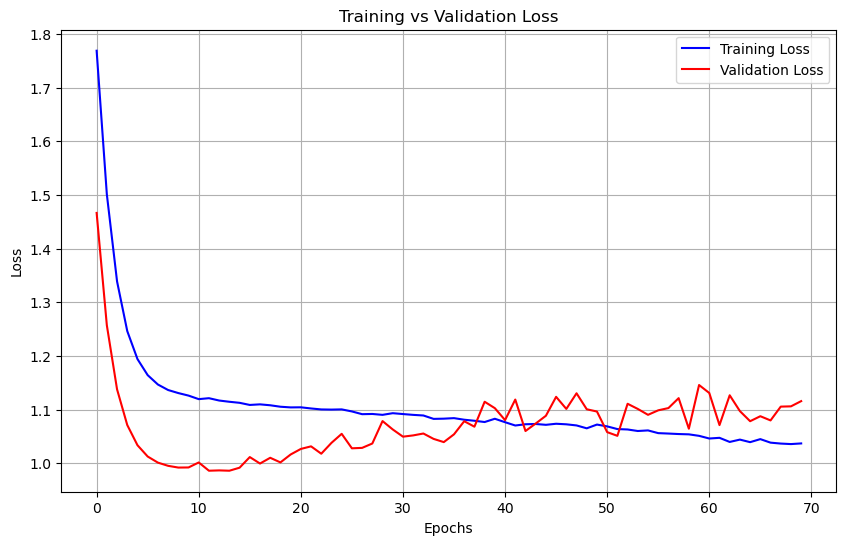

In [71]:
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

## Predict

### Predict with Train Set

In [72]:
#Create the rolling window (90 days)
X_rolling_window_mstr = scaled_train_mstr[-n_past:]  # Shape (n_past, 9)
X_rolling_window_btc = scaled_train_btc[-n_past:]  # Shape (n_past, 9)

# Get the original dates from the DataFrames (before scaling)
dates_rolling_window = train_mstr.index[-n_past:]  # Get the last 90 dates from MSTR
predicted_dates = []  # To store the dates of the predicted 365 days

# Reshape to (1, 90, 9) for prediction since the model expects a batch size of 1
X_rolling_window_mstr = X_rolling_window_mstr.reshape(1, n_past, 9)
X_rolling_window_btc = X_rolling_window_btc.reshape(1, n_past, 9)
# Store all 365 predictions
all_train_predictions = []  

# Keep track of the last predicted date
last_predicted_date = dates_rolling_window[-1]

for i in range(12):  # 12 chunks of 30 days to reach 360 days
    
    #Predict 30 days ahead using both inputs (MSTR + BTC)
    y_pred_train = model.predict({'MSTR_Input': X_rolling_window_mstr, 'BTC_Input': X_rolling_window_btc})  # Shape (1, 30)
    
    #Store the predictions
    all_train_predictions.extend(y_pred_train.flatten())  # Store the 30 predictions as a flat list
    
    #Get the corresponding dates for the predicted 30 days
    new_dates = pd.date_range(start=last_predicted_date, periods=31, freq='D')[1:]  # Generate the next 30 days (skip the last one)
    predicted_dates.extend(new_dates)

    #Update the last predicted date
    last_predicted_date = new_dates[-1]

    #Update the rolling windows with new predicted data
    train_new_mstr_data = np.zeros((30, 9))  # Dummy shape of (30, 9) since you have 9 features
    train_new_btc_data = np.zeros((30, 9))  # Dummy shape of (30, 9) since you have 9 features

    #MSTR Open is at index 1 
    train_new_mstr_data[:, 1] = y_pred_train.flatten()  # Update the MSTR "Open" value
    train_new_btc_data[:, 1] = y_pred_train.flatten()  # (or use your own logic for BTC Open if different)

    #Update X_rolling_window_mstr and X_rolling_window_btc (drop oldest 30 rows, add 30 new predicted rows)
    X_rolling_window_mstr = np.concatenate([X_rolling_window_mstr[:, 30:, :], train_new_mstr_data[np.newaxis, :, :]], axis=1)
    X_rolling_window_btc = np.concatenate([X_rolling_window_btc[:, 30:, :], train_new_btc_data[np.newaxis, :, :]], axis=1)


predicted_df_train = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted_MSTR_Open_Train_Data': all_train_predictions
})


predicted_df_train


/opt/anaconda3/lib/python3.9/site-packages/keras/src/models/functional.py:225: UserWarning:

The structure of `inputs` doesn't match the expected structure: ['MSTR_Input', 'BTC_Input']. Received: the structure of inputs={'MSTR_Input': '*', 'BTC_Input': '*'}



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 356ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


Date  Predicted_MSTR_Open_Train_Data
0   2023-10-06                       -0.251979
1   2023-10-07                       -0.253321
2   2023-10-08                       -0.221247
3   2023-10-09                       -0.211549
4   2023-10-10                       -0.228339
..         ...                             ...
355 2024-09-25                        0.042110
356 2024-09-26                        0.013775
357 2024-09-27                        0.000384
358 2024-09-28                       -0.032282
359 2024-09-29                       -0.050574

[360 rows x 2 columns]

In [73]:
# Convert the list of scaled predictions back to the original scale
scaled_predictions = np.array(all_train_predictions).reshape(-1, 1)

# Inverse transform to get the original scale values using the target_scaler
unscaled_predictions = target_scaler.inverse_transform(scaled_predictions)

# Flatten to 1D
unscaled_predictions = unscaled_predictions.flatten()  


predicted_df_train['Predicted_MSTR_Open_Train_Data_Unscaled'] = unscaled_predictions


In [74]:
predicted_df_train

Date  Predicted_MSTR_Open_Train_Data  \
0   2023-10-06                       -0.251979   
1   2023-10-07                       -0.253321   
2   2023-10-08                       -0.221247   
3   2023-10-09                       -0.211549   
4   2023-10-10                       -0.228339   
..         ...                             ...   
355 2024-09-25                        0.042110   
356 2024-09-26                        0.013775   
357 2024-09-27                        0.000384   
358 2024-09-28                       -0.032282   
359 2024-09-29                       -0.050574   

     Predicted_MSTR_Open_Train_Data_Unscaled  
0                                  25.928022  
1                                  25.899988  
2                                  26.569775  
3                                  26.772287  
4                                  26.421671  
..                                       ...  
355                                32.069279  
356                                31.477589  
357                                31.197943  
358                                30.515808  
359                                30.133823  

[360 rows x 3 columns]

In [75]:
predicted_df_train.columns

Index(['Date', 'Predicted_MSTR_Open_Train_Data',
       'Predicted_MSTR_Open_Train_Data_Unscaled'],
      dtype='object')

In [76]:
# Reset the index and move the current index (Date) to a column
df_mstr_actual_open = df_mstr_actual_open.reset_index()

In [77]:
df_mstr_actual_open.columns

Index(['Date', 'MSTR_Open'], dtype='object')

In [78]:
# Ensure 'Date' columns are in datetime format
predicted_df_train['Date'] = pd.to_datetime(predicted_df_train['Date'])
df_mstr_actual_open['Date'] = pd.to_datetime(df_mstr_actual_open['Date'])

In [79]:
# Check for common dates
common_dates = set(predicted_df_train['Date']) & set(df_mstr_actual_open['Date'])
print("Number of common dates:", len(common_dates))

Number of common dates: 246


In [80]:
predictions_actuals_train = pd.merge(predicted_df_train, df_mstr_actual_open, on='Date', how='inner')

In [81]:
predictions_actuals_train

Date  Predicted_MSTR_Open_Train_Data  \
0   2023-10-06                       -0.251979   
1   2023-10-09                       -0.211549   
2   2023-10-10                       -0.228339   
3   2023-10-11                       -0.205936   
4   2023-10-12                       -0.194721   
..         ...                             ...   
241 2024-09-23                        0.051969   
242 2024-09-24                        0.032537   
243 2024-09-25                        0.042110   
244 2024-09-26                        0.013775   
245 2024-09-27                        0.000384   

     Predicted_MSTR_Open_Train_Data_Unscaled   MSTR_Open  
0                                  25.928022   32.000000  
1                                  26.772287   33.153000  
2                                  26.421671   34.124001  
3                                  26.889503   33.860001  
4                                  27.123692   33.500000  
..                                       ...         ...  
241                                32.275166  147.479996  
242                                31.869379  150.160004  
243                                32.069279  152.300003  
244                                31.477589  157.630005  
245                                31.197943  170.479996  

[246 rows x 4 columns]

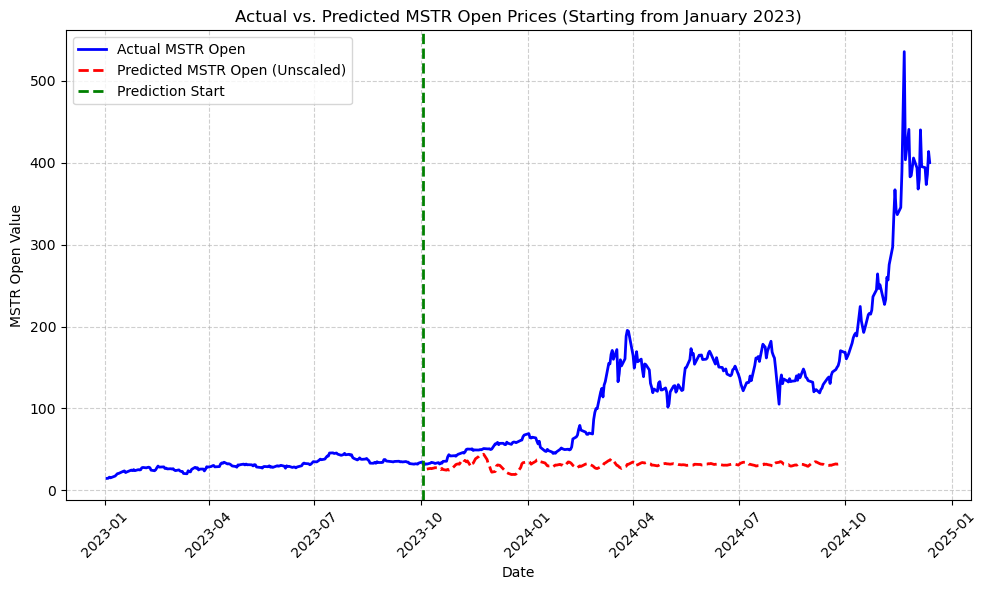

In [82]:
# Ensure Date is a column, not the index, for both DataFrames
df_mstr_actual_open = df_mstr_actual_open.reset_index() if df_mstr_actual_open.index.name == 'Date' else df_mstr_actual_open
predictions_actuals_train = predictions_actuals_train.reset_index() if predictions_actuals_train.index.name == 'Date' else predictions_actuals_train

# Merge the two DataFrames on the Date column, keeping all dates from df_mstr_actual_open
merged_df = pd.merge(
    df_mstr_actual_open[['Date', 'MSTR_Open']], 
    predictions_actuals_train[['Date', 'Predicted_MSTR_Open_Train_Data_Unscaled']], 
    on='Date', 
    how='left'  # Left join to keep all dates from df_mstr_actual_open
)

# Filter to only keep data from January 1st, 2023, onward
merged_df = merged_df[merged_df['Date'] >= '2023-01-01']

# Plot actual vs. predicted values
plt.figure(figsize=(10, 6))
plt.plot(merged_df['Date'], merged_df['MSTR_Open'], label='Actual MSTR Open', color='blue', linewidth=2)
plt.plot(merged_df['Date'], merged_df['Predicted_MSTR_Open_Train_Data_Unscaled'], label='Predicted MSTR Open (Unscaled)', color='red', linestyle='--', linewidth=2)

# Add vertical line for October 3rd, 2023
plt.axvline(x=pd.to_datetime('2023-10-03'), color='green', linestyle='--', label='Prediction Start', linewidth=2)

plt.xlabel('Date')
plt.ylabel('MSTR Open Value')
plt.title('Actual vs. Predicted MSTR Open Prices (Starting from January 2023)')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.6)


plt.tight_layout()
plt.show()

## Evaluate the Model

In [83]:
y_pred_mstr_actual = predictions_actuals_train['Predicted_MSTR_Open_Train_Data_Unscaled'].values
y_actual_mstr = predictions_actuals_train['MSTR_Open'].values

In [84]:

mae_mstr = mean_absolute_error(y_actual_mstr, y_pred_mstr_actual)
mse_mstr = mean_squared_error(y_actual_mstr, y_pred_mstr_actual)
rmse_mstr = np.sqrt(mse_mstr)

print("MSTR Evaluation Metrics (Train):")
print(f"MAE: {mae_mstr:.4f}")
print(f"MSE: {mse_mstr:.4f}")
print(f"RMSE: {rmse_mstr:.4f}")

MSTR Evaluation Metrics (Train):
MAE: 76.3181
MSE: 8058.1080
RMSE: 89.7670


## Predict with Test Set

In [85]:
# Initialize the rolling window (90 days)
X_rolling_window_mstr = scaled_test_mstr[-n_past:]  # Shape (90, 9)
X_rolling_window_btc = scaled_test_btc[-n_past:]  # Shape (90, 9)

# Get the original dates from the DataFrames (before scaling)
dates_rolling_window = test_mstr.index[-n_past:]  # Get the last 90 dates from MSTR
predicted_dates = []  # To store the dates of the predicted 365 days

# Reshape to (1, 90, 9) for prediction (since the model expects a batch size of 1)
X_rolling_window_mstr = X_rolling_window_mstr.reshape(1, 90, 9)
X_rolling_window_btc = X_rolling_window_btc.reshape(1, 90, 9)

all_test_predictions = []  # Store all 365 predictions

for i in range(12):  # 12 chunks of 30 days to reach 360 (or slightly adjust to 365)
    
    #Predict 30 days ahead using both inputs (MSTR + BTC)
    y_pred_test = model.predict({'MSTR_Input': X_rolling_window_mstr, 'BTC_Input': X_rolling_window_btc})  # Shape (1, 30)
    
    #Store the predictions
    all_test_predictions.extend(y_pred_test.flatten())  # Store the 30 predictions as a flat list
    
    #Get the corresponding dates for the predicted 30 days
    last_date = dates_rolling_window[-1]
    new_dates = pd.date_range(start=last_date, periods=31, freq='D')[1:]  # Generate the next 30 days (skip the last one)
    predicted_dates.extend(new_dates)

    #Update the rolling windows using dummys
    new_mstr_data = np.zeros((30, 9))  # Dummy shape of (30, 9) since you have 9 features
    new_btc_data = np.zeros((30, 9))  # Dummy shape of (30, 9) since you have 9 features

    #Assume MSTR Open is at index 1 (based on previous info)
    new_mstr_data[:, 1] = y_pred_test.flatten()  # Update the MSTR "Open" value
    new_btc_data[:, 1] = y_pred_test.flatten()  # (or use your own logic for BTC Open if different)

    #Update X_rolling_window_mstr (drop oldest 30 rows, add 30 new predicted rows)
    X_rolling_window_mstr = np.concatenate([X_rolling_window_mstr[:, 30:, :], new_mstr_data[np.newaxis, :, :]], axis=1)
    X_rolling_window_btc = np.concatenate([X_rolling_window_btc[:, 30:, :], new_btc_data[np.newaxis, :, :]], axis=1)

#Convert list of predictions to a 2D array (n_samples, 1)
predicted_mstr_open_2d = np.array(all_test_predictions).reshape(-1, 1)  # Automatically adapts to any length with (-1, 1)

#Use the target scaler to inverse transform
inversed_predictions = target_scaler.inverse_transform(predicted_mstr_open_2d)

#Ensure both predictions and dates are 1D arrays by flattening 
inversed_predictions_flat = inversed_predictions.flatten() 

# Convert all_test_predictions and predicted_dates to DataFrame
predicted_test_df = pd.DataFrame({
    'Date': predicted_dates,
    'Predicted_MSTR_Open': inversed_predictions_flat  # Ensure it's 1D
})


predicted_test_df

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


Date  Predicted_MSTR_Open
0   2024-12-14            22.200521
1   2024-12-15            19.688795
2   2024-12-16            20.233500
3   2024-12-17            18.420210
4   2024-12-18            17.571873
..         ...                  ...
355 2025-01-08            32.255775
356 2025-01-09            32.071968
357 2025-01-10            31.613785
358 2025-01-11            31.302937
359 2025-01-12            31.015066

[360 rows x 2 columns]